In [49]:
import re

class CAZy_data:
    def __init__(self,filename1,filename2):
        self.data,self.acc,self.seq=[],[],[]
        with open(filename1,'r',encoding='utf-8') as inpt:
            for each in inpt:
                self.data.append(each.rstrip().split('$'))
        with open(filename2,'r',encoding='utf-8') as inpt1:
            for each1 in inpt1:
                if each1.startswith('>'):
                    self.acc.append(each1.rstrip())
                else:
                    self.seq.append(each1.rstrip())
            
                  
    def data_fetch(self,typ,position):
        typ_data=[]
        if typ=='all':
            typ_data=self.data
        else:
            for each in self.data:
                mult=each[position].split(' ')
                if len(mult)==1:#### In case typ = EC, Multi EC number and protein with no EC number are ignore.
                    if mult[0]==typ:
                        typ_data.append(each)
        return typ_data
    
    def EC_GH(self,ec_no,gh_fam):
        self.fasta=[]
        cazy_ec=self.data_fetch(ec_no,1)
        cazy_gh=self.data_fetch(gh_fam,-1)
        self.common_data=[[i[0],i[1],i[3],i[4],i[-2],i[-1]] for i in cazy_ec if i in cazy_gh]
        rm_prt, rm_prt_fasta=[],[]
        for each in range(len(self.common_data)):
            t=self.common_data[each]
            if self.prtn_filter(t[0]):
                all_acc=t[3].split(' ')
                if all_acc[0]!='':
                    for e_acc in all_acc:
                        e_seq=self.seq_fetch(e_acc)
                        try:
                            create_error=0/len(e_seq) # to remove accession number which doesnt have hits
                            self.fasta.append(f'>{e_acc}${t[0]}${t[1]}${t[2]}${t[-2]}${t[-1]}')
                            self.fasta.append(e_seq[0])
                        except ZeroDivisionError:
                            rm_prt_fasta.append(e_acc)
            else:
                rm_prt.append(t)
#         print('Total number of sequences:',len(self.fasta)/2)
#         print('Number of removed partial or fragment proteins (CAZy):',len(rm_prt))
#         print('Number of removed partial or fragment proteins (Fasta):',len(rm_prt_fasta))
        return self.fasta,rm_prt,rm_prt_fasta
    def prtn_filter(self,prt_name):
        hit=1
        if re.search('partial|fragment',prt_name.lower()):
            hit-=1
        return hit
            
    def seq_fetch(self,accession):
        hits=[]
        temp=0
        for each in range(len(self.acc)):
            if re.search(f'{accession}\D',self.acc[each]):
                temp+=1
                
                if self.prtn_filter(self.acc[each]): # remove partial| fragment accession numbers from GenBank description
                    hits.append(self.seq[each])
        if temp>1:
            print(f'Multiple hits for {accession}')
        elif temp==0:
            print(f'No hits for {accession}')
        return hits
    
class Sequence:
    def __init__(self,filename):
        self.data=[]
        if type(filename)==str:
            with open(filename,'r') as inpt:
                for each in inpt:
                    self.data.append(each.rstrip())
        else:
            self.data=filename
                       
    def output(self):
        a,s,l=[],[],[]
        unusual=0
        no_dup,dup=self.remove_dup(self.ml_sl())
        sig_fam,mlti=self.multi_fam(no_dup)
        for ele in sig_fam:
            if ele.startswith('>'):
                a.append(ele)
            else:
                if re.search('[UZOBJX]',ele.upper()):
#                     print(a[-1])
                    del a[-1]
                    unusual+=1
                    continue
                l.append(len(ele))
                s.append(ele.upper())
#         print('The length of the smallest sequence:',min(l))
#         print('Sequence with "X" present:',unusual)
        return a,s,l,unusual,dup,mlti
    
    def multi_fam(self,duta): # remove the same accession number present in multiple families
        temp=defaultdict(list)
        for ii in range(0,len(duta),2):
            name=duta[ii].split('$')[0][1:]
            temp[name].append([duta[ii],duta[ii+1]])
            
        new_duta,mut=[],[]
        for jj,kk in dict(temp).items():
            if len(kk)!=1:
                mut.append(jj)
            else:
                new_duta.append(kk[0][0])
                new_duta.append(kk[0][1])
        return new_duta,mut

    def remove_dup(self,datu): # remove the duplicates 
        temp_acc,temp_seq,temp_acc_seq=[],[],[]
        dup=[]  
        for iii in range(0,len(datu),2):
            if datu[iii] not in temp_acc:
                temp_acc.append(datu[iii])
                temp_acc_seq.append(datu[iii])
                temp_acc_seq.append(datu[iii+1])
            else:
                dup.append(datu[iii])
        return temp_acc_seq,len(dup)
               
    def ml_sl(self):
        acc_seq=[]
        for k in range(len(self.data)):
            if self.data[k].startswith('>'):
                acc_seq.append(self.data[k])
                join_=0
                for l in range(k+1,len(self.data)):
                    if self.data[l].startswith('>') == False:
                        join_+=1
                    else:
                        break
                acc_seq.append(''.join(self.data[k+1:k+1+join_]))
        return acc_seq
     
In_data=CAZy_data('/home/rakesh/research/CAZy_23_6_22/cazy_char_10_6_22.txt','/home/rakesh/research/CAZy_23_6_22/char_gh_23_6_22.txt')

In [11]:
class add_filter:
    def __init__(self,ac,se):
        self.ac=ac
        self.se=se
    def present_absent(self,typ,data):
        print('Filter has been applied....')
        new_acc,new_seq=[],[]
        not_acc,not_seq=[],[]
        for i in range(len(self.ac)):
            if self.ac[i].split('$')[-1] in data:
                new_acc.append(self.ac[i])
                new_seq.append(self.se[i])
            else:
                not_acc.append(self.ac[i])
                not_seq.append(self.se[i])
        if typ=='present':
            return new_acc,new_seq
        elif typ=='absent':
            return not_acc,not_seq
        else:
            print('Check the spelling!!!')

In [50]:
t1=time.perf_counter()
total_data=[]
total_rm_cazy,total_rm_genbank={},{}
value_error,no_entry=[],[]

ddaa={}
ddaa['3.2.1.8']={'GH10':408,'GH11':409}
for each,peach in ddaa.items():
    ec_number=each
    gh_family='all'
    cazy_acc_seq,rm_cazy,rm_genbank=In_data.EC_GH(ec_number,gh_family) # write all to fetch all the EC number or all the GH family
    total_rm_cazy[each],total_rm_genbank[each]=rm_cazy,rm_genbank
    acc,seq,min_len,x_aa,dupli,multi_gh=Sequence(cazy_acc_seq).output()
    print(f'Sequence has been collected for {each}....')
    
######## Filtered applied #################################

    acc,seq=add_filter(acc,seq).present_absent('present',list(peach.keys()))
    
######## Taking equal size GH families #####################

#     acc,seq=balance_data(acc,seq).sizing(peach)

No hits for BAA31551.1
No hits for NP_149279.1
No hits for NP_149217.1
No hits for AAC98123.1
No hits for ABI49937.1
No hits for AAC98140.1
No hits for CAA82319.1
No hits for NP_242986.1
No hits for ZP_08160171.1
No hits for ZP_08159615.1
No hits for ACR61562.1
No hits for BAA19777.1
No hits for ADQ57411.1
No hits for YP_003851606.1
No hits for AAZ56824.1
No hits for AAZ56956.1
No hits for CAD48748.1
No hits for NP_227886.1
No hits for NP_227877.1
No hits for AAD32593.1
No hits for NP_644553.1
No hits for AAP31839.1
No hits for EAA78230.1
No hits for XP_002470423.1
No hits for XP_365543.1
No hits for BAA89465.1
No hits for NP_241765.1
No hits for CAD65888.1
No hits for ZP_08160424.1
No hits for ZP_08158180.1
No hits for ZP_08157788.1
No hits for NP_624448.1
No hits for NP_626540.1
No hits for BAA19778.1
No hits for AAZ55251.1
No hits for ABA39289.1
No hits for ABM55503.1
No hits for EAA73188.1
No hits for XP_383800.1
No hits for XP_368051.1
No hits for AAD37441.1
No hits for A44594
No 

In [58]:
outp=open('3i2i1i8_GH10_GH11.txt','w') 
for yu,zu in zip(acc,seq):
    outp.write(yu+'\n')
    outp.write(zu+'\n')
outp.close()

In [60]:
import subprocess
import time
import pandas as pd
from collections import defaultdict
import copy
from itertools import combinations_with_replacement,combinations
import sys
import os

filename='3i2i1i8_GH10_GH11.txt'
prtns=filename.split('.')[0]
os.mkdir(prtns)

class per_ident:
    def __init__(self,file):
        self.acc,self.seq=[],[]
        with open(file,'r') as inpt:
            for i in inpt:
                if i.startswith('>'):
                    self.acc.append(i)
                else:
                    self.seq.append(i)
                    
    def create_files(self):
        total_data=[]
        for i in range(len(self.acc)):
            main_out=open('main_temp.txt','w')
            main_out.write(self.acc[i]+self.seq[i])
            main_out.close()
            for j in range(i+1,len(self.acc)):
                out=open('temp.txt','w')
                out.write(self.acc[j]+self.seq[j])
                out.close()
                data=self.blast('main_temp.txt','temp.txt')
                if data==[]:
                    data=['\t'.join([self.acc[i].rstrip().split(' ')[0][1:],self.acc[j].rstrip().split(' ')[0][1:],'0','0','0'])]# change the number of 0 based on number parameters taken
                total_data.extend(data)
        final_out=open(f'{prtns}/{prtns}_pairwise_blastp.txt','w')
        for k in total_data:
            final_out.write(k+'\n')
        final_out.close()
        
    def blast(self,file1,file2):
        data=[]
        subprocess.run(f' blastp -query {file1} -subject {file2} -outfmt "6 qseqid sseqid pident qcovs qcovhsp" -out result.txt',
               shell=True,stdout=subprocess.PIPE,check=True,universal_newlines=True)
        with open('result.txt','r') as inpt:
            for i in inpt:
                data.append(i.rstrip())
        return data
    
class pairwise_matrix:
    def __init__(self,file3):
        self.temp=[]
        self.multi_hit=defaultdict(list)
        with open(file3,'r') as inpt:
            for i in inpt:
                j=i.rstrip().split('\t')
                name=j[0]+'&'+j[1]
                self.temp.append(j)
                self.multi_hit[name].append([float(fl_i) for fl_i in j[2:]])
                
    def matrix(self,typ,pq):
        if pq=='PI':
            noo=0
        elif pq=='QC':
            noo=-1
        else:
            sys.exit('Dude!!! what do you want % identity or % query coverage...')
        self.collect=defaultdict(list)
        for i,j in dict(self.multi_hit).items():
            j=sorted(j,key=lambda x:x[-1], reverse= True)
            j=j[0] # hsp with high query coverage is taken
            if j[0]>=pi_cutoff and j[-1]>=qc_cutoff: # pi=percentage identity and qc=query coverage
                j_1=j
            else:
                j_1=[0,0,0]
            i1=i.split('&')
            self.collect[i1[0]].append(j_1[noo])
        self.collect[i1[1]]=[] # for the last accession number, eg 8&9 is last in list and we need 9.
        self.collect=dict(self.collect)
        le=len(self.collect)
        for k,l in self.collect.items():
            diff=le-len(l)
            tem=[]
            for m in range(diff):
                tem.append(0)
            l=tem+l
            self.collect[k]=l
        df=pd.DataFrame(self.collect, index=self.collect.keys()).astype(float)
        label=[]
        for each in alpha.acc:
            tt=each.rstrip()[1:].split('$')[typ]
            label.append(tt)
        df.index=df.columns=label
        for ro_co in range(le):
            df.iloc[ro_co,ro_co]=-1
        dff=copy.copy(df.T)
        return dff.round(decimals=1)
    
class matrix_analysis:
    def __init__(self,ax,nam):
        self.nam=nam
        self.uniq=[]
        self.each_len=[]
        for eaa in list(ax.index):
            if eaa not in self.uniq:
                self.uniq.append(eaa)
#         self.uniq=['c','lalba']
#         self.uniq=['g','c','ch']
        self.name='_'.join(self.uniq)
        self.comb = list(combinations_with_replacement(self.uniq, 2))
        out=open(f'{prtns}/{prtns}_compare_pair_identity_{pi_cutoff}_{qc_cutoff}_{self.nam}.txt','w')
        self.dat={}
        for jj in self.comb:
            temp=jj[0]+','+jj[1]
        #     print(temp)
            self.dat[temp]=[]
            rl=len(ax.index)
            cl=len(ax.columns)
            for kk in range(rl):
                for ll in range(cl):
                    if kk+ll <rl:
                        if ax.index[kk]==jj[0] and ax.columns[kk+ll]==jj[1]:
                            self.dat[temp].append(float(ax.iloc[kk,kk+ll]))
            hj=[xy for xy in list(self.dat[temp]) if xy != -1]
            hj.sort()
            self.dat[temp]=hj
            self.each_len.append(len(hj))
            temp1=12-len(temp)
            temp2=f'{hj[:5]}'[1:-1]
            temp21=36-len(temp2)
            temp3=f'{hj[-5:]}'[1:-1]
#             print(temp,' '*temp1,'min:',temp2,' '*temp21,'max:',temp3,'\n')
            out.write(temp+' '*temp1+'min: '+temp2+' '*temp21+'ax: '+temp3+'\n')
        out.close()
        
    def overlapping(self):
        common={}
        stat={}
        cwr=list(combinations(self.uniq,2))
        for i in cwr:
            x=i[0]+','+i[1]
            y=i[0]+','+i[0]
            z=i[1]+','+i[1]
            for j in [y,z]:
                temp=[q for q in self.dat[x] if q>=min(self.dat[j])]
                common[f'{x}/{j}']=temp
                stat[f'{x}/{j}']=[len(self.dat[x]),len(self.dat[j]),min(self.dat[j]),len(temp)]
        dfuc=pd.DataFrame(stat,index=['#hybrid(H)','#identical(I)','min(%I)','H>min(%I)']).astype(int)
        dfuc.to_excel(f'{prtns}/{prtns}_per_ident_stat_{pi_cutoff}_{qc_cutoff}_{self.nam}.xlsx')
        
    def to_excel(self):
        graph_data=copy.copy(self.dat)
        for gh1,gh2 in graph_data.items():
            if max(self.each_len)>len(gh2):
                diff=(max(self.each_len)-len(gh2))*['']
                graph_data[gh1].extend(diff)
        df1=pd.DataFrame(graph_data)
        df1.to_excel(f'{prtns}/{prtns}_per_ident_plot_{pi_cutoff}_{qc_cutoff}_{self.nam}.xlsx',index=False)

class pi_qc_scatter:
    def __init__(self,data):
        self.data=data.T
        self.label=self.data.index
        
    def each_com(self):
        l=len(self.label)
        tem=defaultdict(list)
        for i in range(l):
            for j in range(i+1,l):
                tem[f'{self.label[i]},{self.label[j]}'].append(self.data.iloc[j,i])
        return dict(tem)

start=time.perf_counter()
pi_cutoff=0
qc_cutoff=0
alpha=per_ident(filename)
alpha.create_files()

# .matrix(a,b) where a=0:'acc',1:'prtn',2:'ec',3:'org',4:'species',5:'ghf', b=PI:per_ident,QC:query_cover
pi_qc={}
c={}
a=pairwise_matrix(f'{prtns}/{prtns}_pairwise_blastp.txt')
for part in ['PI','QC']:
    pi_qc[part]=a.matrix(5,part)################################### Change with feature
    b=matrix_analysis(pi_qc[part],part)
    b.overlapping()
    b.to_excel()
    c[part]=pi_qc_scatter(pi_qc[part]).each_com()
d={}
for c1 in list(c[part].keys()):
    goat=[]
    for c2,c3 in zip(c['PI'][c1],c['QC'][c1]):
        goat.append([c2,c3])
    d[c1]=sorted(goat,key=lambda x:x[0])
a3=pi_qc['PI']+pi_qc['QC'].T
a3.to_excel(f'{prtns}/{prtns}_pariwise_blastp_matrix_{pi_cutoff}_{qc_cutoff}.xlsx')
# -2 in the matrix represent the % identity and % query coverages diagonal values got added (-1-1=-2)
stop=time.perf_counter()
print('The total time take:',round((stop-start),2),'sec')


The total time take: 35856.57 sec


In [31]:
alpha

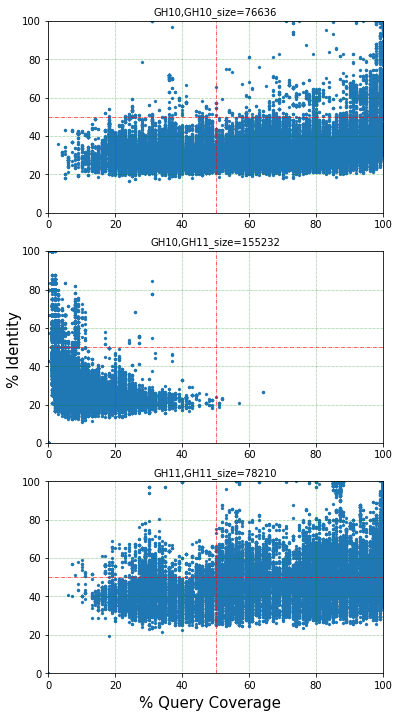

In [61]:
import matplotlib.pyplot as plt
new_list=list(combinations_with_replacement(b.uniq,2))
# new_cord=list(combinations_with_replacement([no for no in range(3)],2))
fig, axs = plt.subplots(3,1,figsize=(6, 12)) ###################################### need manual input
fig.subplots_adjust(hspace=0.2, wspace=0.1)
ref1=[z for z in range(101)]
ref2=[50 for z in range(101)]
for axis,ax in zip(new_list,axs.ravel()):
    new_axis=axis[0]+','+axis[1]
#     print(new_axis)
    u1=[u[0] for u in d[new_axis]]
    v1=[v[1] for v in d[new_axis]]
    ax.scatter(v1,u1,linewidth=0.1,s=10)
    ax.plot(ref1,ref2,color='r',linestyle = '-.',linewidth=0.6)
    ax.plot(ref2,ref1,color='r',linestyle = '-.',linewidth=0.6)
    ax.set_title(f'{new_axis}_size={len(u1)}',fontsize=10)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.grid(color = 'green', linestyle = ':', linewidth = 0.5)
    


fig.text(0.5, 0.085, '% Query Coverage', ha='center',fontsize=15)
fig.text(0.03, 0.5, '% Identity', va='center', rotation='vertical',fontsize=15)
fig.savefig(f'{prtns}.png',dpi=300)
plt.show()

